# COMP579 Assignment 2

**Coding: Tabular RL [70 points]**

In [25]:
pip install gym==0.26.2 # Installs latest version; a bit different than V 0.25

In [26]:
import gym

import numpy as np
import matplotlib.pyplot as plt

In [27]:
from tqdm import tqdm   # use as tqdm(arr)
# import random

In [28]:
import pdb


In [29]:
def softmax(Q_s, temp, sample = True): # sample dictates if want to return policy or next action
  # given Q(s,a) for a given state s, return next action according to policy
  preference = np.asarray(Q_s/temp)

  stable_preference = preference - np.max(preference) # Handle num overflow issues

  policy_numerator = np.exp(stable_preference)
  policy_denominator = np.sum(policy_numerator)

  policy = policy_numerator/policy_denominator # policy given state s

  action = np.random.choice(a=np.size(policy),p=policy)

  return action if sample == True else policy

In [30]:
class Sarsa:
  def __init__(self, env, alpha, gamma, temp):
    # write your solution here
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.Q = np.zeros((env.observation_space.n,env.action_space.n)) # 500 x 6 for Taxi

  def select_action(self, s, greedy=False):
    # write your solution here

    if greedy:
      # if finished training, then choose the optimal policy
      return np.argmax(self.Q[s,:]) # Return argmax Q(s,a) over choice of a

    else:
      return softmax(self.Q[s,:], self.temp)

  def update(self, s, a, r, s_prime, a_prime, done):
    # write your solution here

    if not done: # target = r + gamma*Q(s',a')
      self.Q[s,a] = self.Q[s,a] + self.alpha * (r + self.gamma * self.Q[s_prime,a_prime] - self.Q[s,a])

    else: # target = r
      self.Q[s,a] = self.Q[s,a] + self.alpha * (r - self.Q[s,a])

    return


class ExpectedSarsa:
  def __init__(self, env, alpha, gamma, temp):
    # write your solution here
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.Q = np.zeros((env.observation_space.n,env.action_space.n)) # 500 x 6 for Taxi
    #return

  def select_action(self, s, greedy=False):
    # write your solution here
    if greedy:
      # if finished training, then choose the optimal policy
      return np.argmax(self.Q[s,:]) # Return argmax Q(s,a) over choice of a
    else:
      return softmax(self.Q[s,:], self.temp)

  def update(self, s, a, r, s_prime, a_prime, done):
    # write your solution here
    if not done: # target = r + gamma*E[Q(s',a')|s']
      policy = softmax(self.Q[s_prime,:], self.temp, sample = False)
      expectation = np.dot(self.Q[s_prime,:],policy)
      self.Q[s,a] = self.Q[s,a] + self.alpha * (r + self.gamma * expectation  - self.Q[s,a])

    else: # target = r
      self.Q[s,a] = self.Q[s,a] + self.alpha * (r - self.Q[s,a])

    return
""" Implementation is at the bottom
####################### bonus question, optional
class Hybrid_Sarsa_Q:
  def __init__(self, env, alpha, gamma, tau,temp = 0.1,epsilon = 0.2):
    # write your solution here
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.epsilon = epsilon
    self.tau = tau
    self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
    return

  #epsilon greedy approach
  def select_action(self, s, greedy=False):
    # s is the current state
    possible_actions = np.array(self.Q[s,:])
    random_number = np.random.uniform(0, 1)
    if self.epsilon < random_number or greedy:
      # if finished training, then choose the optimal policy
      return np.argmax(possible_actions)
    else:
      return self.env.action_space.sample()

  def update(self, s, a, r, s_prime):
    possible_actions = np.array(self.Q[s_prime,:])

    #get the probability of each action using e greedy policy
    best_action = np.argmax(possible_actions)
    for action in range(len(possible_actions)):
      if action == best_action:
        possible_actions[action] = (1 - self.epsilon) + (self.epsilon / len(possible_actions))
      else:
        possible_actions[action] = self.epsilon / len(possible_actions)

    expected_sarsa_target = 0

    for i in range(len(possible_actions)):
      expected_sarsa_target += possible_actions[i] * self.Q[s_prime,i]
    expected_sarsa_target = expected_sarsa_target * self.tau

    q_learning_target = (1-self.tau) * np.max(self.Q[s_prime,:])
    target = expected_sarsa_target + q_learning_target
    target = target + r - self.Q[s,a]

    self.Q[s,a] = self.Q[s,a] + self.alpha *  target
    return
  """

# Write your experiment code below

In [31]:
env_name = 'Taxi-v3'
env = gym.make(env_name)
#print("Action space:", env.action_space)
# print("State space:", env.observation_space)

In [32]:
# function that runs each episode
def run_episode(sarsa_obj, greedy = False): # greedy==True means we are testing

  s = sarsa_obj.env.reset()[0] # Reset env and get init observation
  done = False
  total_r = 0 # Useful for the plots
  a = sarsa_obj.select_action(s,greedy = greedy)

  while not done:

    s_prime,r,truncated,terminated,info = sarsa_obj.env.step(a) # New version of gym --> 5 outputs
    done = truncated or terminated

    total_r+= r

    # Choose a_prime from s_prime using policy
    if greedy:
      # if finished training, then choose the optimal policy
      a_prime = sarsa_obj.select_action(s_prime,greedy = greedy) # Return argmax Q(s,a) over choice of a
    else:
      a_prime = sarsa_obj.select_action(s_prime,greedy = greedy)
      sarsa_obj.update(s, a, r, s_prime, a_prime, done) # update only when testing


    s = s_prime
    a = a_prime

  return total_r


# function that runs each hyperparameter setting
def run_experiments(env, sarsa_cls, discount_rate, lrs,temps, num_trials=10, num_segments=500):
  # returns a tuple of: list of mean return for the learning curves, corresp. sd, max and min of each experiment

  best_mean_by_segment = [] # To return best experiment mean as a function of segment
  best_sd_by_segment = []

  final_train_perf_by_exp = [] # To return avg. final performance for each experiment
  final_test_perf_by_exp = []

  uncertainty_train_by_exp = [] # Return the uncertainty by exp
  uncertainty_test_by_exp = []

  for temp in tqdm(temps):

    for lr in lrs: # Loop through each experiment

      # Instantiate sarsa_obj based on hyperparamters
      sarsa_obj = sarsa_cls(env, lr, discount_rate, temp)

      # Intermediates to help in updating final_test/train_perf_by_exp
      train_performance_by_trial = []
      test_performance_by_trial = []


      # Need the uncertainty of each exp
      min_train = float('inf')
      max_train = float('-inf')
      min_test = float('inf')
      max_test = float('-inf')

      mean_by_segment = []
      var_by_segment = np.asarray([])

      for trial in range(num_trials):

        trial_mean_by_segment = []

        for segment in range(num_segments):

          segment_returns = []



          for ep in range(11):

            if ep <=9: # Train_ep
              ep_return = run_episode(sarsa_obj, greedy = False)
              segment_returns.append(ep_return)

            else: # Test_ep
              ep_return = run_episode(sarsa_obj, greedy = True)
              segment_returns.append(ep_return)

          # Append avg. segment performance of algorithm
          trial_mean_by_segment.append(np.mean(segment_returns))


          if segment == num_segments - 1: # final segment

            # Append final performances for this trial
            train_performance_by_trial.append(np.mean(segment_returns[:-1]))
            test_performance_by_trial.append(segment_returns[-1])

            # Find min/max return over the performance phase for this exp.
            if np.min(segment_returns[:-1]) < min_train:
              min_train = np.min(segment_returns[:-1])

            if np.max(segment_returns[:-1]) > max_train:
              max_train = np.max(segment_returns[:-1])

            if segment_returns[-1] < min_test:
              min_test = segment_returns[-1]

            if segment_returns[-1] > max_test:
              max_test = segment_returns[-1]

        # Once done trial must update mean_by_segment with the trial_mean_by_segment
        if trial == 0:
          mean_by_segment = np.asarray(trial_mean_by_segment)
          var_by_segment = np.zeros(len(trial_mean_by_segment))

        else: # Incrementally update avg. and sd
          delta = (np.asarray(trial_mean_by_segment) - mean_by_segment)
          mean_by_segment = mean_by_segment + 1/(trial+1) * delta
          var_by_segment = var_by_segment + np.multiply((np.asarray(trial_mean_by_segment) - mean_by_segment),delta)


      # Once done all trials:

      # 1) Append results to resp. lists
      final_train_perf_by_exp.append(np.mean(train_performance_by_trial))
      final_test_perf_by_exp.append(np.mean(test_performance_by_trial))

      uncertainty_train_by_exp.append((min_train,max_train))
      uncertainty_test_by_exp.append((min_test,max_test))

      # 2) Check if best parameter setting using final_test_perf as a criteria
      final_test_perf = np.mean(test_performance_by_trial)

      if final_test_perf >= np.max(final_test_perf_by_exp):
        # Then update best_mean_by_segment
        best_mean_by_segment = mean_by_segment
        best_sd_by_segment = np.sqrt(var_by_segment/(num_trials - 1)) # Sample sd (hence / by (n-1)) [and we know that we have 10 trials > 1]




  # Remains to return values of interest
  # Transform the lists to make it easier to plot later: Row => all values related to a given temp

  # Unzip into max and min values
  uncertainty_train_by_exp = list(zip(*uncertainty_train_by_exp))
  uncertainty_test_by_exp =  list(zip(*uncertainty_test_by_exp))
  # Reshape for ease
  uncertainty_train_by_exp = [np.reshape(uncertainty_train_by_exp[0],(-1,len(lrs))) , np.reshape(uncertainty_train_by_exp[1],(-1,len(lrs)))]
  uncertainty_test_by_exp = [np.reshape(uncertainty_test_by_exp[0],(-1,len(lrs))) , np.reshape(uncertainty_test_by_exp[1],(-1,len(lrs)))]


  return (best_mean_by_segment,best_sd_by_segment, np.reshape(final_train_perf_by_exp,(-1,len(lrs))), np.reshape(final_test_perf_by_exp,(-1,len(lrs))),
          uncertainty_train_by_exp, uncertainty_test_by_exp)


### Graphs

In [21]:
sarsas = [(Sarsa,'SARSA'), (ExpectedSarsa,'Expected SARSA')]
lrs = [0.03, 0.5, 1]
temps = [0.1, 0.5, 0.9]
gamma = 1 # Since epsiodic tasks
num_plots = 3
num_segments=500


# for sarsa_cls,sarsa_name in sarsas:
# Run experiments for both sarsas
sarsa_best_mean_by_segment,sarsa_best_sd_by_segment, sarsa_final_train_perf_by_exp,sarsa_final_test_perf_by_exp,sarsa_uncertainty_train_by_exp, sarsa_uncertainty_test_by_exp = run_experiments(env, sarsas[0][0],gamma, lrs,temps, num_trials=10, num_segments=500)
Esarsa_best_mean_by_segment,Esarsa_best_sd_by_segment, Esarsa_final_train_perf_by_exp,Esarsa_final_test_perf_by_exp,Esarsa_uncertainty_train_by_exp, Esarsa_uncertainty_test_by_exp = run_experiments(env, sarsas[1][0],gamma, lrs,temps, num_trials=10, num_segments=500)


  0%|          | 0/3 [03:27<?, ?it/s]


KeyboardInterrupt: 

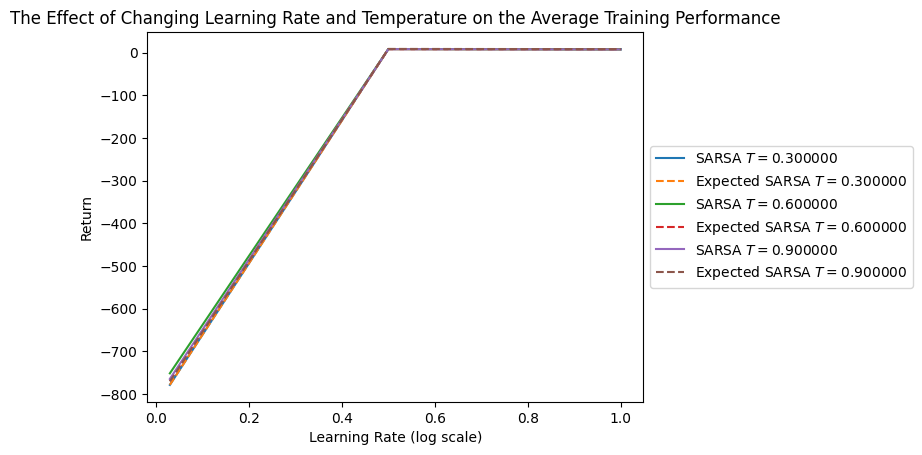

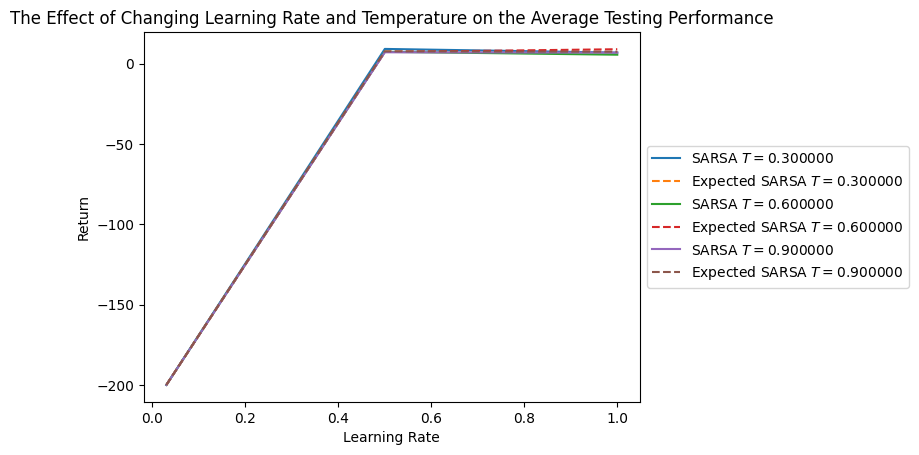

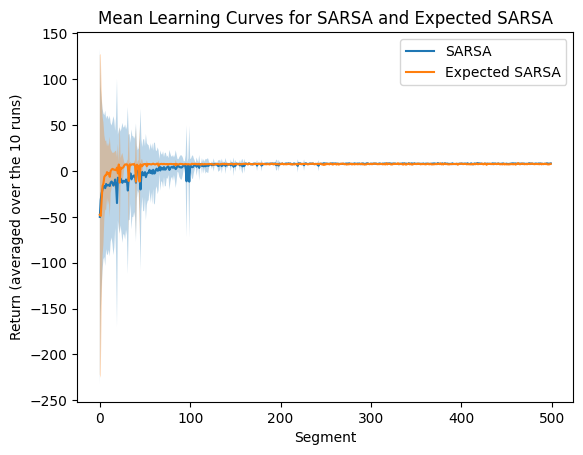

In [33]:
for i in range(num_plots):
  fig, ax = plt.subplots()

  if i == 0: # Plot 'The Effect of Learning Rate and Temperature on the Average Training Performance'

    legend_handles = []
    # draw final_train_perf_by_exp
    for temp_idx,temp in enumerate(temps):
      # SARSA
      sarsa_performance_at_temp = sarsa_final_train_perf_by_exp[temp_idx,:]

      plt_perf_at_temp, = ax.plot(lrs,sarsa_performance_at_temp, label = 'SARSA ' + r"$T = %f$" %temp, linestyle = 'solid')
      legend_handles.append(plt_perf_at_temp)

      # E(SARSA)
      Esarsa_performance_at_temp = Esarsa_final_train_perf_by_exp[temp_idx,:]

      plt_perf_at_temp, = ax.plot(lrs,Esarsa_performance_at_temp, label = 'Expected SARSA ' + r"$T = %f$" %temp, linestyle = 'dashed')
      #ax.set_yscale('log') ####################################
      legend_handles.append(plt_perf_at_temp)

      '''
      # draw uncertainty using shading

      #plot shading SARSA
      min_returns = sarsa_uncertainty_train_by_exp[0][temp_idx,:]
      max_returns = sarsa_uncertainty_train_by_exp[1][temp_idx,:]
      ax.fill_between(lrs, min_returns, max_returns, alpha=0.3)

      # plot shading E(SARSA)
      min_returns = Esarsa_uncertainty_train_by_exp[0][temp_idx,:]
      max_returns = Esarsa_uncertainty_train_by_exp[1][temp_idx,:]
      ax.fill_between(lrs, min_returns, max_returns, alpha=0.3)
      '''

    ax.set_xlabel("Learning Rate (log scale)")
    ax.set_ylabel("Return") #(averaged over the last 10 training episodes and the 10 runs)
    ax.set_title("The Effect of Changing Learning Rate and Temperature on the Average Training Performance")
    ax.legend(handles=legend_handles,loc ='center left',bbox_to_anchor=(1,0.5))

    #plt.show()

  if i == 1: # Plot 'The Effect of Learning Rate and Temperature on the Average Testing Performance'

    legend_handles = []
    # draw final_test_perf_by_exp
    for temp_idx,temp in enumerate(temps):

      # SARSA
      sarsa_performance_at_temp = sarsa_final_test_perf_by_exp[temp_idx,:]

      plt_perf_at_temp, = ax.plot(lrs,sarsa_performance_at_temp, label = 'SARSA ' + r"$T = %f$" %temp, linestyle = 'solid')
      legend_handles.append(plt_perf_at_temp)

      # E(SARSA)
      Esarsa_performance_at_temp = Esarsa_final_test_perf_by_exp[temp_idx,:]

      plt_perf_at_temp, = ax.plot(lrs,Esarsa_performance_at_temp, label = 'Expected SARSA ' + r"$T = %f$" %temp, linestyle = 'dashed')
      #ax.set_yscale('log') ####################################
      legend_handles.append(plt_perf_at_temp)

      '''
      # draw uncertainty using shading

      #plot shading SARSA
      min_returns = sarsa_uncertainty_train_by_exp[0][temp_idx,:]
      max_returns = sarsa_uncertainty_train_by_exp[1][temp_idx,:]
      ax.fill_between(lrs, min_returns, max_returns, alpha=0.3)

      # plot shading E(SARSA)
      min_returns = Esarsa_uncertainty_train_by_exp[0][temp_idx,:]
      max_returns = Esarsa_uncertainty_train_by_exp[1][temp_idx,:]
      ax.fill_between(lrs, min_returns, max_returns, alpha=0.3)
      '''

    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Return") #(averaged over the 10 runs)
    ax.set_title("The Effect of Changing Learning Rate and Temperature on the Average Testing Performance")
    ax.legend(handles=legend_handles,loc ='center left',bbox_to_anchor=(1,0.5))

    #plt.show()

  if i == 2: # Plot 'Mean Learning Curves for SARSA and Expected SARSA'
    legend_handles = []

    # SARSA
    plt_sarsa_curve, = ax.plot(sarsa_best_mean_by_segment, label = 'SARSA', linestyle = 'solid')
    legend_handles.append(plt_sarsa_curve)
    ax.fill_between(np.arange(0,500), (sarsa_best_mean_by_segment) - (sarsa_best_sd_by_segment), (sarsa_best_mean_by_segment) + (sarsa_best_sd_by_segment), alpha=0.3)

    # E(SARSA)
    plt_Esarsa_curve, = ax.plot(Esarsa_best_mean_by_segment, label = 'Expected SARSA', linestyle = 'solid')
    legend_handles.append(plt_Esarsa_curve)
    ax.fill_between(np.arange(0,500), np.asarray(Esarsa_best_mean_by_segment) - np.asarray(Esarsa_best_sd_by_segment), np.asarray(Esarsa_best_mean_by_segment) + np.asarray(Esarsa_best_sd_by_segment), alpha=0.3)


    ax.set_xlabel("Segment")
    ax.set_ylabel("Return (averaged over the 10 runs)")
    ax.set_title("Mean Learning Curves for SARSA and Expected SARSA")
    ax.legend(handles=legend_handles)



In [ ]:
sarsa_final_test_perf_by_exp

In [ ]:
sarsa_final_train_perf_by_exp

In [ ]:
for i in range(num_plots):
  fig, ax = plt.subplots()

  if i == 0: # Plot 'The Effect of Learning Rate and Temperature on the Average Training Performance'

    legend_handles = []
    # draw final_train_perf_by_exp
    for temp_idx,temp in enumerate(temps):
      # SARSA
      sarsa_performance_at_temp = sarsa_final_train_perf_by_exp[temp_idx,:]

      plt_perf_at_temp, = ax.plot(lrs,sarsa_performance_at_temp, label = 'SARSA ' + r"$T = %f$" %temp, linestyle = 'solid')
      legend_handles.append(plt_perf_at_temp)

      # E(SARSA)
      Esarsa_performance_at_temp = Esarsa_final_train_perf_by_exp[temp_idx,:]

      plt_perf_at_temp, = ax.plot(lrs,Esarsa_performance_at_temp, label = 'Expected SARSA ' + r"$T = %f$" %temp, linestyle = 'dashed')
      #ax.set_yscale('log') ####################################
      legend_handles.append(plt_perf_at_temp)


      # draw uncertainty using shading

      #plot shading SARSA
      min_returns = sarsa_uncertainty_train_by_exp[0][temp_idx,:]
      max_returns = sarsa_uncertainty_train_by_exp[1][temp_idx,:]
      ax.fill_between(lrs, min_returns, max_returns, alpha=0.3)

      # plot shading E(SARSA)
      min_returns = Esarsa_uncertainty_train_by_exp[0][temp_idx,:]
      max_returns = Esarsa_uncertainty_train_by_exp[1][temp_idx,:]
      ax.fill_between(lrs, min_returns, max_returns, alpha=0.3)


    ax.set_xlabel("Learning Rate (log scale)")
    ax.set_ylabel("Return") #(averaged over the last 10 training episodes and the 10 runs)
    ax.set_title("The Effect of Changing Learning Rate and Temperature on the Average Training Performance")
    ax.legend(handles=legend_handles,loc ='center left',bbox_to_anchor=(1,0.5))

    #plt.show()

  if i == 1: # Plot 'The Effect of Learning Rate and Temperature on the Average Testing Performance'

    legend_handles = []
    # draw final_test_perf_by_exp
    for temp_idx,temp in enumerate(temps):

      # SARSA
      sarsa_performance_at_temp = sarsa_final_test_perf_by_exp[temp_idx,:]

      plt_perf_at_temp, = ax.plot(lrs,sarsa_performance_at_temp, label = 'SARSA ' + r"$T = %f$" %temp, linestyle = 'solid')
      legend_handles.append(plt_perf_at_temp)

      # E(SARSA)
      Esarsa_performance_at_temp = Esarsa_final_test_perf_by_exp[temp_idx,:]

      plt_perf_at_temp, = ax.plot(lrs,Esarsa_performance_at_temp, label = 'Expected SARSA ' + r"$T = %f$" %temp, linestyle = 'dashed')
      #ax.set_yscale('log') ####################################
      legend_handles.append(plt_perf_at_temp)


      # draw uncertainty using shading

      #plot shading SARSA
      min_returns = sarsa_uncertainty_train_by_exp[0][temp_idx,:]
      max_returns = sarsa_uncertainty_train_by_exp[1][temp_idx,:]
      ax.fill_between(lrs, min_returns, max_returns, alpha=0.3)

      # plot shading E(SARSA)
      min_returns = Esarsa_uncertainty_train_by_exp[0][temp_idx,:]
      max_returns = Esarsa_uncertainty_train_by_exp[1][temp_idx,:]
      ax.fill_between(lrs, min_returns, max_returns, alpha=0.3)


    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Return") #(averaged over the 10 runs)
    ax.set_title("The Effect of Changing Learning Rate and Temperature on the Average Testing Performance")
    ax.legend(handles=legend_handles,loc ='center left',bbox_to_anchor=(1,0.5))

    #plt.show()

  if i == 2: # Plot 'Mean Learning Curves for SARSA and Expected SARSA'
    legend_handles = []

    # SARSA
    plt_sarsa_curve, = ax.plot(sarsa_best_mean_by_segment, label = 'SARSA', linestyle = 'solid')
    legend_handles.append(plt_sarsa_curve)
    ax.fill_between(np.arange(0,500), (sarsa_best_mean_by_segment) - (sarsa_best_sd_by_segment), (sarsa_best_mean_by_segment) + (sarsa_best_sd_by_segment), alpha=0.3)

    # E(SARSA)
    plt_Esarsa_curve, = ax.plot(Esarsa_best_mean_by_segment, label = 'Expected SARSA', linestyle = 'solid')
    legend_handles.append(plt_Esarsa_curve)
    ax.fill_between(np.arange(0,500), np.asarray(Esarsa_best_mean_by_segment) - np.asarray(Esarsa_best_sd_by_segment), np.asarray(Esarsa_best_mean_by_segment) + np.asarray(Esarsa_best_sd_by_segment), alpha=0.3)


    ax.set_xlabel("Segment")
    ax.set_ylabel("Return (averaged over the 10 runs)")
    ax.set_title("Mean Learning Curves for SARSA and Expected SARSA")
    ax.legend(handles=legend_handles)



Code for optional question 3 c)

In [44]:
# bonus question, optional
class Hybrid_Sarsa_Q:
  def __init__(self, env, alpha, gamma, temp, epsilon, tau):
    # write your solution here
    self.env = env
    self.alpha = alpha
    self.gamma = gamma
    self.temp = temp
    self.epsilon = epsilon
    self.tau = tau
    self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
    self.Q = np.array(self.Q, dtype=np.float64)
    return

  #epsilon greedy approach
  def select_action(self, s, greedy=False):
    # s is the current state
    possible_actions = np.array(self.Q[s,:])
    random_number = np.random.uniform(0, 1)
    if self.epsilon < random_number or greedy:
      # if finished training, then choose the optimal policy
      return np.argmax(possible_actions)
    else:
      return self.env.action_space.sample()

  def update(self, s, a, r, s_prime):
    possible_actions = np.array(self.Q[s_prime,:])

    #get the probability of each action using e greedy policy
    best_action = np.argmax(possible_actions)
    for action in range(len(possible_actions)):
      if action == best_action:
        possible_actions[action] = (1 - self.epsilon) + (self.epsilon / len(possible_actions))
      else:
        possible_actions[action] = self.epsilon / len(possible_actions)

    expected_sarsa_target = 0

    for i in range(len(possible_actions)):
      expected_sarsa_target += possible_actions[i] * self.Q[s_prime,i]
    expected_sarsa_target = expected_sarsa_target * self.tau

    q_learning_target = (1-self.tau) * np.max(self.Q[s_prime,:])
    target = expected_sarsa_target + q_learning_target
    target = target + r - self.Q[s,a]

    self.Q[s,a] = self.Q[s,a] + self.alpha *  target
    return

  def run(self,episodes):
    training_R = 0
    steps = 0
    # run the training episodes
    for episode in range(episodes):
      steps = 0
      total_reward = 0
      #reset env and initialise s
      s, info = self.env.reset()
      terminal = False
      while not terminal:

        a = self.select_action(s)

        # take action a and get new state s_prime
        s_prime,reward,terminated,truncated,info = self.env.step(a)

        #update q table
        self.update(s,a,reward,s_prime)
        s = s_prime
        total_reward += reward
        steps += 1
        terminal = terminated or truncated
      training_R += total_reward

    # run the testing episode
    testing_R = 0
    steps = 0
    #reset env and initialise s and a
    s, info = self.env.reset()
    terminal = False
    while not terminal:
        # select new action a
        a = self.select_action(s, greedy=True)
        # take action a and get new state s
        s,reward,terminated,truncated,info = self.env.step(a)
        testing_R += reward
        steps += 1
        terminal = terminated or truncated
    training_return = training_R / episodes
    testing_return = testing_R

    return training_return, testing_return

KeyboardInterrupt: 

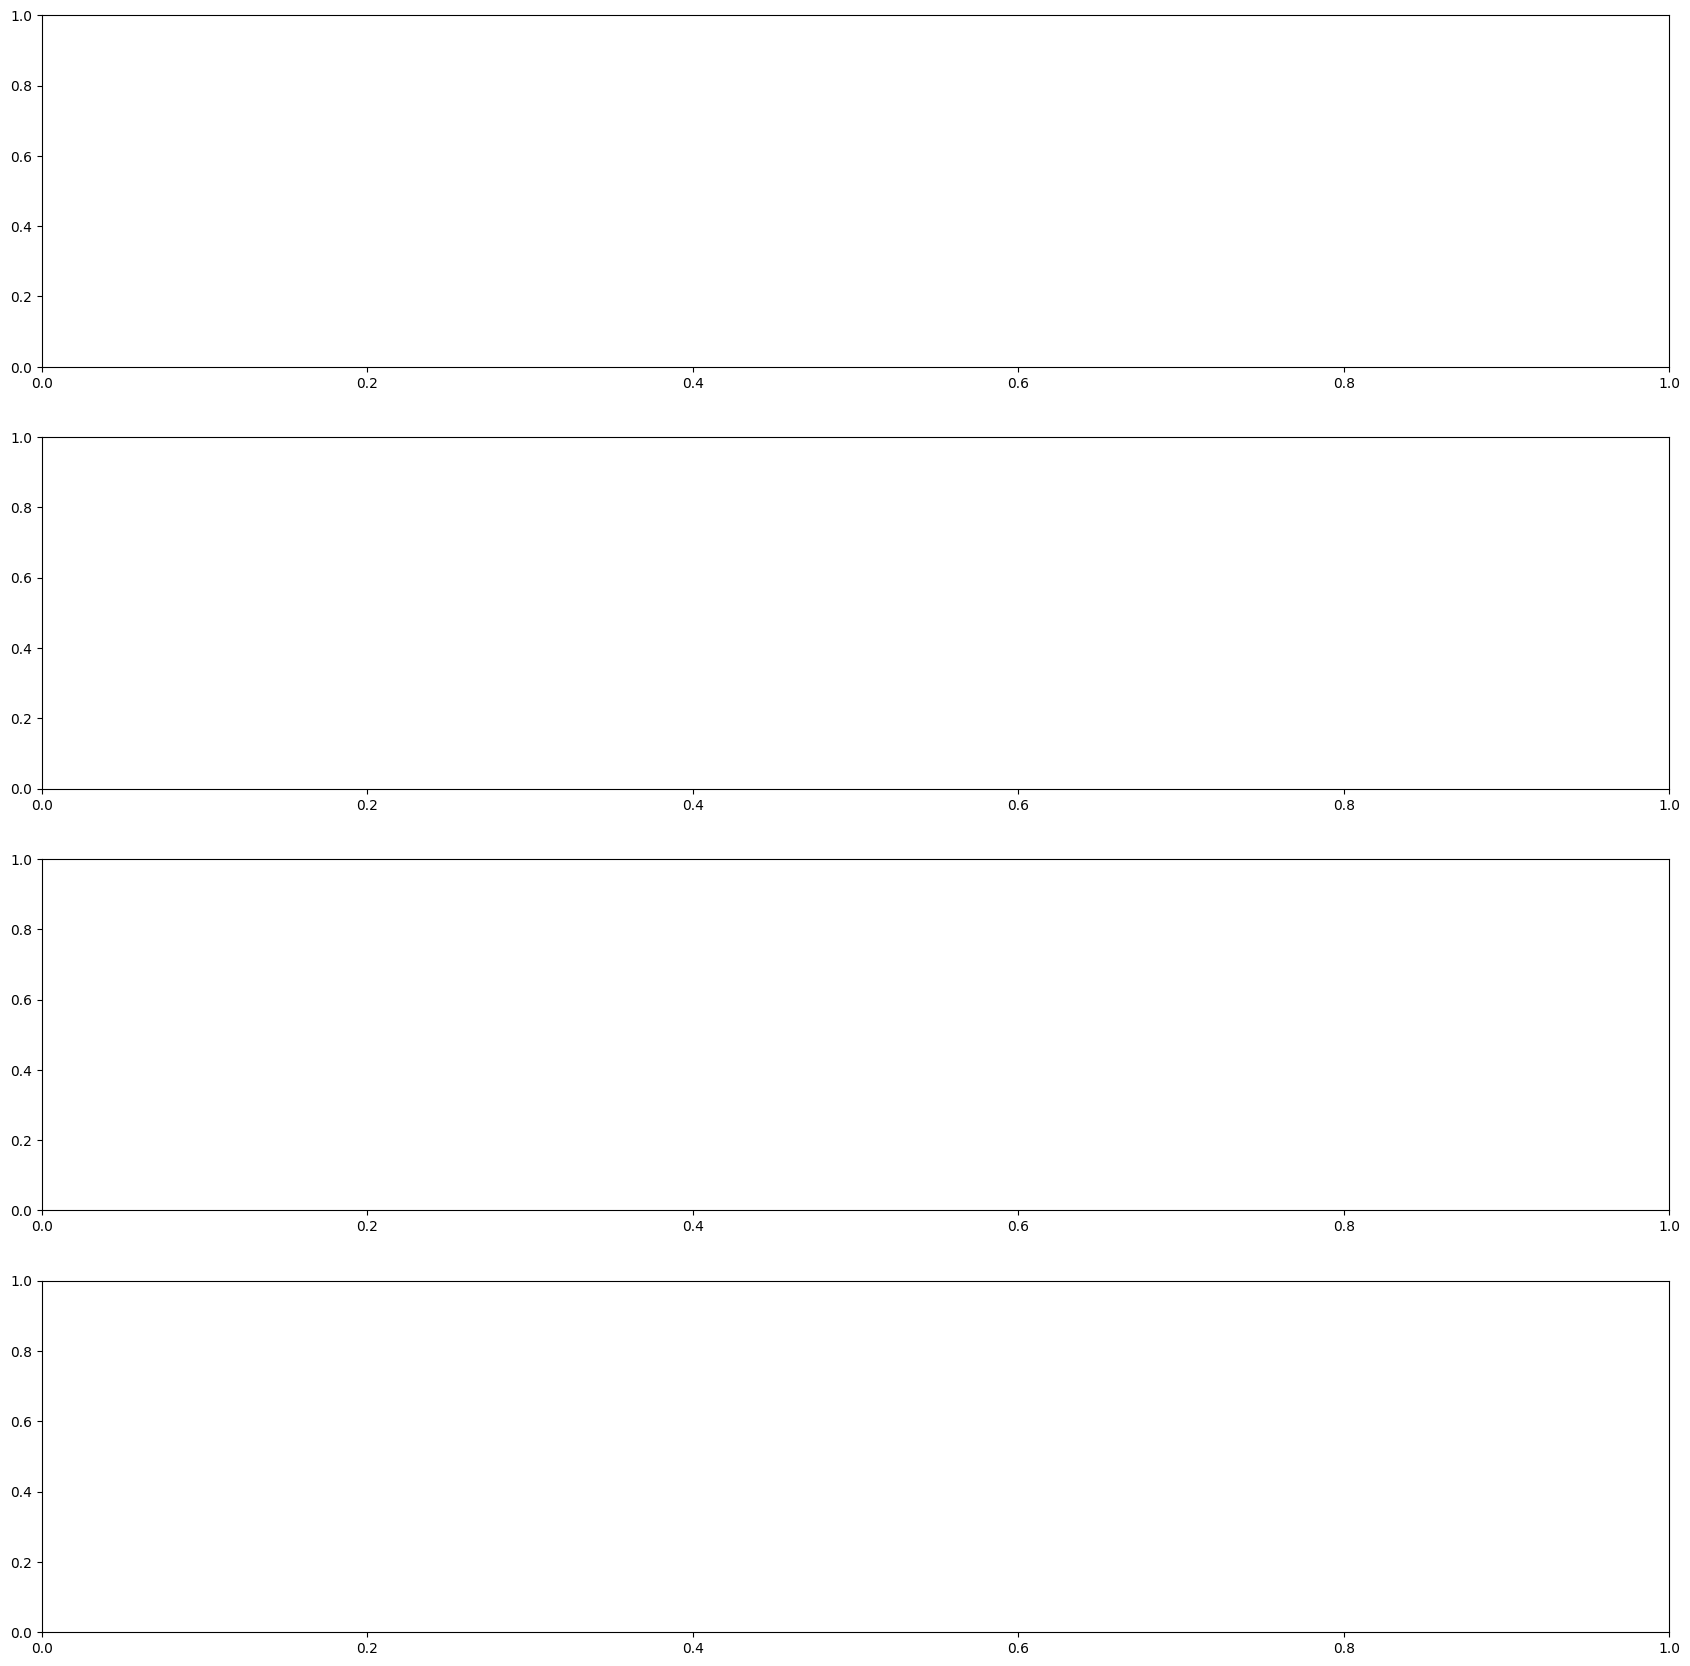

In [45]:
# function that runs each experiment

trials = 10                           #trials
segments = 500                       #segments
episodes = 10                         #episodes
gamma = 1                           #discount factor
epsilon = 0.1

#hyper parameters
alphas = [0.1,0.5, 1]    #learning rates
temps =  [0.3,0.6,0.9]     #temperatures
taus = [ 0, 0.5, 1]  #range of alpha values


all_training_returns = []
all_testing_returns = []

best_mean_by_segment = [] # To return best experiment mean as a function of segment
best_sd_by_segment = []


# for best hyper param selection
final_test_perf = []

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(21, 21))

for tau in taus:
    #lists of the returns for each temp
    average_training_returns = []

    max_average_training_returns = []

    min_average_training_returns = []

    average_testing_returns = []

    for alpha in alphas:
        training_return_over_trials = []

        testing_return_over_trials = []

        mean_by_segment = []
        var_by_segment = np.asarray([])

        for trial in range(trials):
            hybrid_sarsa = Hybrid_Sarsa_Q(env,alpha,gamma,temps[0], epsilon,tau)

            testing_return = 0
            training_return = 0

            trial_mean_by_segment = []

            for segment in range(segments):
                training_return, testing_return = hybrid_sarsa.run(episodes)

                # get the return for the segment which is 11 episodes
                segment_return = (training_return * episodes + testing_return) / 11
                trial_mean_by_segment.append(segment_return)



            training_return_over_trials.append(training_return)

            testing_return_over_trials.append(testing_return)

            if trial == 0:
                mean_by_segment = np.asarray(trial_mean_by_segment)
                var_by_segment = np.zeros(len(trial_mean_by_segment))

            else: # Incrementally update avg. and sd
                delta = (np.asarray(trial_mean_by_segment) - mean_by_segment)
                mean_by_segment = mean_by_segment + 1/(trial+1) * delta
                var_by_segment = var_by_segment + np.multiply((np.asarray(trial_mean_by_segment) - mean_by_segment),delta)




        average_training_returns.append(np.mean(training_return_over_trials))

        max_average_training_returns.append(np.max(training_return_over_trials))

        min_average_training_returns.append(np.min(training_return_over_trials))

        testing_return_over_trials = np.asarray(testing_return_over_trials)

        average_testing_returns.append(np.mean(testing_return_over_trials))

        # Check if best parameter setting using final_test_perf as a criteria
        final_test_perf.append(np.mean(testing_return_over_trials))

        final_performance = np.mean(testing_return_over_trials)

        if final_performance >= np.max(final_test_perf):
            # Then update best_mean_by_segment
            best_mean_by_segment = mean_by_segment
            best_sd_by_segment = np.sqrt(var_by_segment/(trials - 1)) # Sample sd (hence / by (n-1)) [and we know that we have 10 trials > 1]


    #plot the training returns over learning rates

    learning_rates = np.asarray(alphas)
    training_returns = np.asarray(average_training_returns)

    all_training_returns.append(training_returns)

    ax[0].plot(learning_rates,training_returns , label = "Sarsa alpha= %s" %tau)

    ax[0].fill_between(learning_rates, min_average_training_returns, max_average_training_returns, alpha=0.4)

    ax[0].legend()
    ax[0].set_xlabel("Learning Rate")
    ax[0].set_ylabel("Training Returns")
    ax[0].set_title("Training Returns for values of learning rate  with uncertainty")

    #plot the training returns over learning rates without the uncertainty

    ax[1].plot(learning_rates,training_returns , label = "Sarsa alpha= %s" %tau)

    ax[1].legend()
    ax[1].set_xlabel("Learning Rate")
    ax[1].set_ylabel("Training Returns")
    ax[1].set_title("Training Returns for values of learning rate without uncertainty")

    #plot the testing returns over learning rates

    testing_returns = np.asarray(average_testing_returns)

    all_testing_returns.append(testing_returns)

    ax[2].plot(learning_rates,testing_returns , label = "Sarsa alpha= %s" %tau)

    ax[2].legend()
    ax[2].set_xlabel("Learning Rate")
    ax[2].set_ylabel("Testing Returns")
    ax[2].set_title("Testing Returns for values of learning rate")


# plot learning curve for sarsa

segment_number = list(range(0, segments))

max_learning_curve = best_mean_by_segment + best_sd_by_segment
min_learning_curve = best_mean_by_segment - best_sd_by_segment

ax[3].plot(segment_number,best_mean_by_segment , label = "Sarsa mean", color = 'red')
ax[3].fill_between(segment_number, min_learning_curve, max_learning_curve, alpha=0.4)

ax[3].legend()
ax[3].set_xlabel("Segments")
ax[3].set_ylabel("Return")
ax[3].set_title("Learning curves")








plt.show()

# function that runs each hyperparameter setting